Epoch 1/50


/tmp/ipykernel_13974/1810535042.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0607 - val_loss: 0.0416
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0405 - val_loss: 0.0389
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0361 - val_loss: 0.0326
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0360 - val_loss: 0.0367
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0327 - val_loss: 0.0323
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0341 - val_loss: 0.0322
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0284 - val_loss: 0.0322
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0315 - val_loss: 0.0325
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0304 - val_loss: 0.0320
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0278 - val_loss: 0.0321
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0303 - val_loss: 0.0326
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0280 - val_l

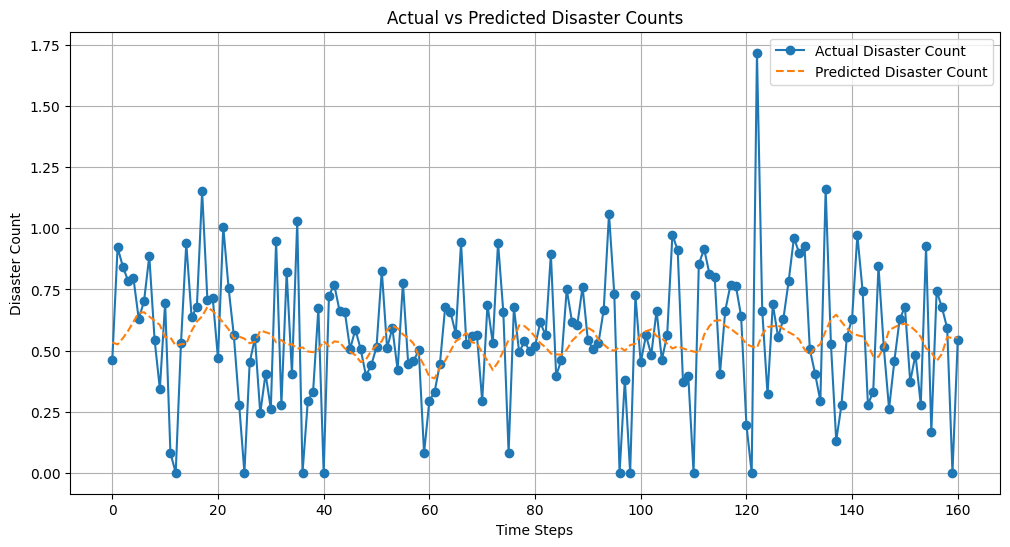

In [27]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

# Log transformation to manage outliers
monthly_disasters['disaster_count'] = np.log1p(monthly_disasters['disaster_count'])

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)

# Create Sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        label = data.iloc[i + seq_length, 0]  # Predict disaster count
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 36  # Increased sequence length to capture longer dependencies
X, y = create_sequences(scaled_df, seq_length)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.4),  # Increased dropout for regularization
    Dense(1)  # Output disaster count
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # Lower learning rate for fine-tuning

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
y_pred = model.predict(X_test)

# Rescale Predictions
y_pred_rescaled = np.expm1(y_pred)  # Reverse log transformation
y_test_rescaled = np.expm1(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Disaster Count', marker='o')
plt.plot(y_pred_rescaled, label='Predicted Disaster Count', linestyle='--')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_13974/2847463257.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size().reset_index(name='disaster_count')
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.8020 - val_loss: 0.6085
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5489 - val_loss: 0.4110
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3671 - val_loss: 0.2734
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2414 - val_loss: 0.1797
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1563 - val_loss: 0.1168
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0991 - val_loss: 0.0753
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0615 - val_loss: 0.0486
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0375 - val_loss: 0.0317
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0225 - val_loss: 0.0212
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077 - val_loss: 0.0112
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0043 - val_l

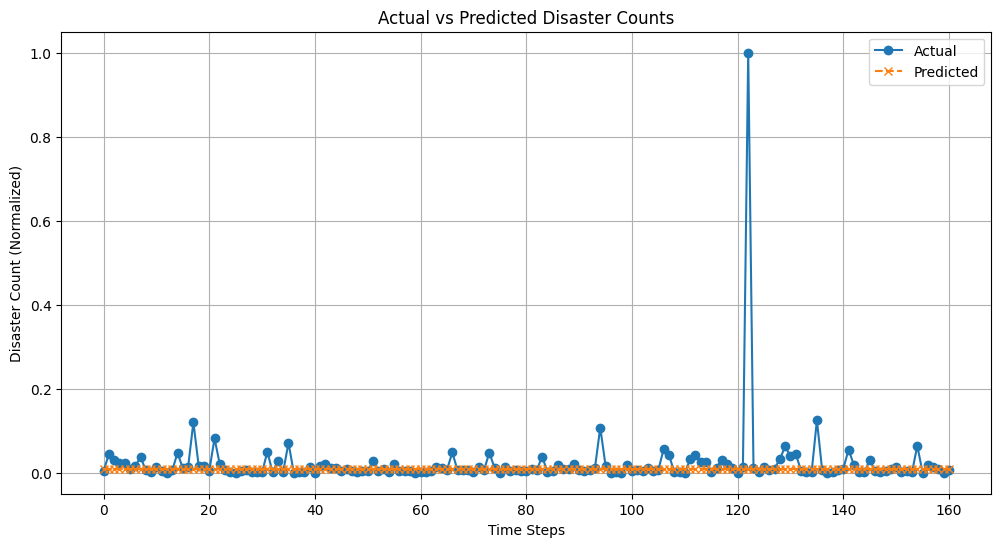

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load dataset
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter data to relevant columns
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date'])
df = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size().reset_index(name='disaster_count')

# Normalize disaster counts
scaler = MinMaxScaler()
df['disaster_count'] = scaler.fit_transform(df[['disaster_count']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]['disaster_count'].values.reshape(-1, 1)
        label = data.iloc[i + seq_length]['disaster_count']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Set sequence length and create sequences
seq_length = 36
X, y = create_sequences(df, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape y_train and y_test for multi-output (if applicable)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Build the LSTM model
fine_tuned_lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(y_train.shape[1])  # Match the output shape to y_train
])

# Compile the model
fine_tuned_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = fine_tuned_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Make predictions
y_pred = fine_tuned_lstm_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Fine-Tuned LSTM Model RMSE: {rmse}")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count (Normalized)')
plt.legend()
plt.grid()
plt.show()
